In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

success


### Processing images
#### Example taken from: https://www.kaggle.com/seyunhan/inceptionresnetv2-keras-pbl4

We load the train,test,val images here

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
17696,fffb900a92289a33.jpg,[healthy]
17697,fffc488fa4c0e80c.jpg,[scab]
17698,fffc94e092a59086.jpg,[rust]
17699,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2037
frog_eye_leaf_spot    4139
healthy               4396
powdery_mildew        1210
rust                  1963
scab                  5435
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

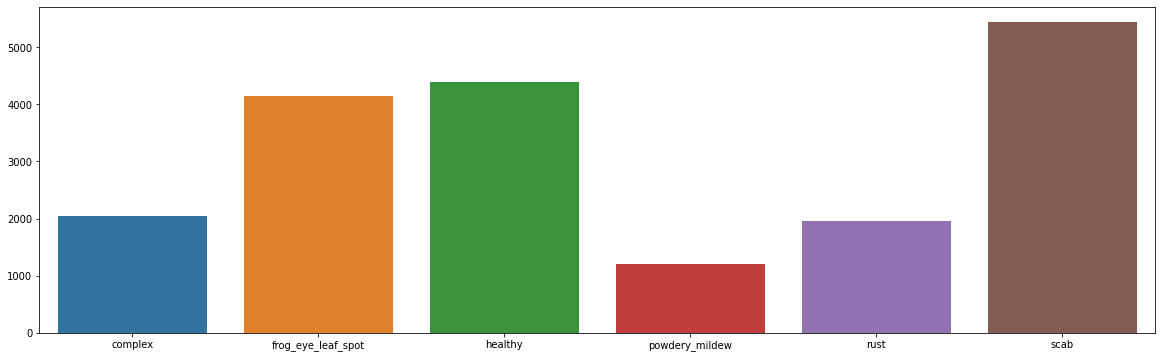

In [4]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

### Viewing some images

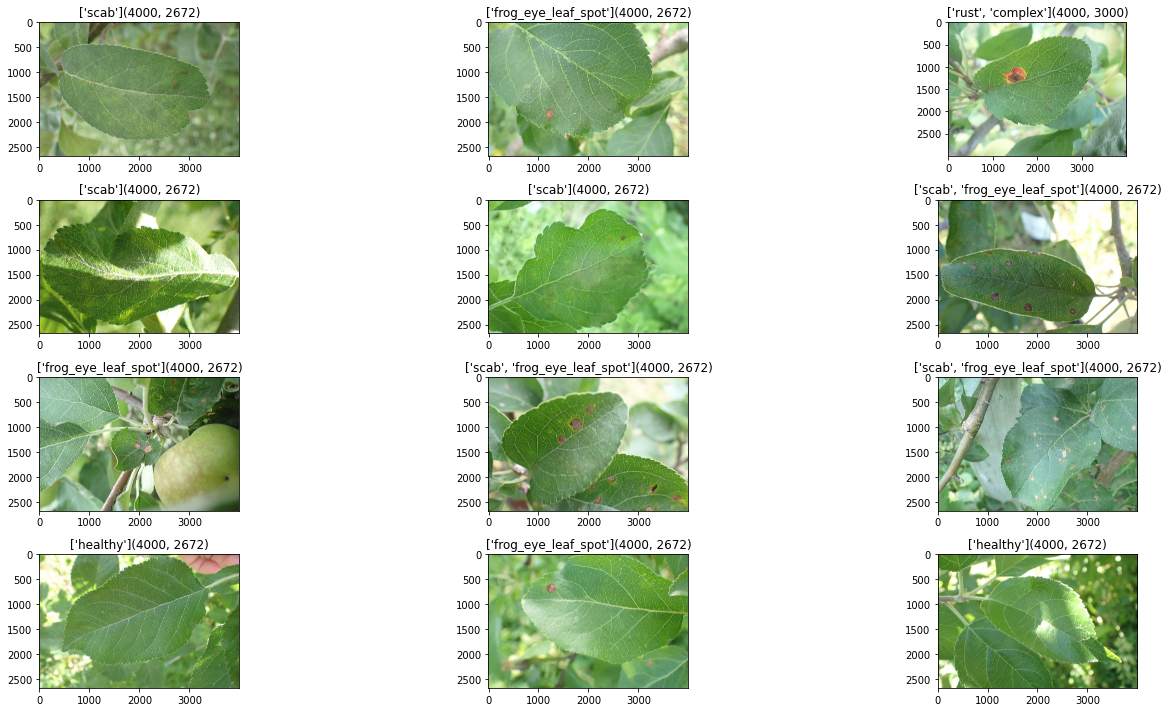

In [5]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('./train_images/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [6]:
from keras.preprocessing.image import ImageDataGenerator

TARGET_SIZE = 480

datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(TARGET_SIZE,TARGET_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

#'../input/plant-pathology-2021-fgvc8/train_images'
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(TARGET_SIZE,TARGET_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

Found 15931 validated image filenames belonging to 6 classes.
Found 1770 validated image filenames belonging to 6 classes.


In [7]:
import h5py

In [8]:
seed = 1200
tf.random.set_seed(seed)

# weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224, 3))
# model = keras.applications.NASNetLarge(input_shape=(331, 331, 3), include_top=False, weights='imagenet', classes=1000)
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 13, 13, 1536), dtype=tf.float32, name=None), name='conv_7b_ac/Relu:0', description="created by layer 'conv_7b_ac'")


In [9]:
new_model = tf.keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(6, 
        kernel_initializer=keras.initializers.RandomUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])

# Freezing the weights
for layer in new_model.layers[:-1]:
    layer.trainable=False
    
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 13, 13, 1536)     54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense_top (Dense)           (None, 6)                 9222      
                                                                 
Total params: 54,345,958
Trainable params: 9,222
Non-trainable params: 54,336,736
_________________________________________________________________


In [10]:
## TO use CPU
CUDA_VISIBLE_DEVICES=""
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
print('success')

success


In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

# tf.config.experimental.set_memory_growth(
#     physical_devices[0], enable='True'
# )

# import PIL.Image

Num GPUs Available:  0


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
import PIL
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')

new_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=4, mode='max', restore_best_weights=True)
history = new_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=65,
                    steps_per_epoch=train_generator.samples//256, # = 58
                    validation_steps=valid_generator.samples//128,
                    callbacks=callbacks)


C:\Users\riley\AppData\Local\Temp\ipykernel_4628\3583829206.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=train_generator,


Epoch 1/65
62/62 [==============================] - 611s 10s/step - loss: 0.4597 - accuracy: 0.2999 - f1_score: 0.1866 - val_loss: 0.4145 - val_accuracy: 0.4135 - val_f1_score: 0.2089
Epoch 2/65
62/62 [==============================] - 625s 10s/step - loss: 0.4041 - accuracy: 0.4360 - f1_score: 0.2962 - val_loss: 0.3921 - val_accuracy: 0.4519 - val_f1_score: 0.3466
Epoch 3/65
62/62 [==============================] - 613s 10s/step - loss: 0.3820 - accuracy: 0.4945 - f1_score: 0.3926 - val_loss: 0.3554 - val_accuracy: 0.5048 - val_f1_score: 0.3824
Epoch 4/65
62/62 [==============================] - 630s 10s/step - loss: 0.3600 - accuracy: 0.5343 - f1_score: 0.4466 - val_loss: 0.3493 - val_accuracy: 0.5409 - val_f1_score: 0.4336
Epoch 5/65
62/62 [==============================] - 628s 10s/step - loss: 0.3570 - accuracy: 0.5197 - f1_score: 0.4311 - val_loss: 0.3615 - val_accuracy: 0.4760 - val_f1_score: 0.3941
Epoch 6/65
62/62 [==============================] - 631s 10s/step - loss: 0.3535

## Making predictions

In [13]:
for img_name in tqdm(test['image']):
    path = './test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./test_size256_images/{img_name}')

100%|██████████| 931/931 [01:31<00:00, 10.13it/s]


In [14]:
test_data = datagen.flow_from_dataframe(
    test,
    directory = './test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (TARGET_SIZE,TARGET_SIZE),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = new_model.predict(test_data)
preds = preds.tolist()

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
    
print(indices)

Found 931 validated image filenames.
[[1], [2], [0], [1], [3], [0], [3], [2], [0], [0], [2], [2], [4], [2], [1], [2], [2], [2], [3], [2], [4], [1], [3], [3], [5], [5], [0], [0], [2], [0], [3], [2], [0], [2], [5], [1], [3], [5], [5], [2], [5], [2], [2], [2], [4], [2], [2], [2], [2], [2], [5], [3], [2], [3], [4], [0, 1], [5], [2], [1], [2], [5], [2], [2], [1], [1], [5], [4], [1], [2], [0], [2], [0], [5], [4], [5], [0], [1], [1], [5], [5], [0], [3], [2], [0], [2], [4], [3], [2], [3], [3], [2], [4], [3], [5], [5], [2], [2], [1], [0, 1], [2], [0], [5], [2], [1], [5], [5], [2], [2], [2], [2], [1], [2], [2], [5], [2], [1], [0, 4], [2], [0], [3], [2], [4], [2], [1], [4], [5], [5], [5], [1], [2], [5], [5], [2], [4], [0], [5], [5], [2], [2], [2], [4], [2], [0, 4], [1], [1], [1], [2], [5], [4], [0], [4], [4], [2], [4], [2], [2], [5], [1], [3], [5], [3], [2], [3], [5], [5], [3], [2], [2], [2], [2], [1], [1], [2], [1], [1], [2], [2], [0, 5], [2], [1], [2], [1], [2], [2], [2], [2], [2], [2], [1], [5

In [15]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['frog_eye_leaf_spot', 'healthy', 'complex', 'frog_eye_leaf_spot', 'powdery_mildew', 'complex', 'powdery_mildew', 'healthy', 'complex', 'complex', 'healthy', 'healthy', 'rust', 'healthy', 'frog_eye_leaf_spot', 'healthy', 'healthy', 'healthy', 'powdery_mildew', 'healthy', 'rust', 'frog_eye_leaf_spot', 'powdery_mildew', 'powdery_mildew', 'scab', 'scab', 'complex', 'complex', 'healthy', 'complex', 'powdery_mildew', 'healthy', 'complex', 'healthy', 'scab', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'scab', 'healthy', 'scab', 'healthy', 'healthy', 'healthy', 'rust', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'scab', 'powdery_mildew', 'healthy', 'powdery_mildew', 'rust', 'complex frog_eye_leaf_spot', 'scab', 'healthy', 'frog_eye_leaf_spot', 'healthy', 'scab', 'healthy', 'healthy', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'scab', 'rust', 'frog_eye_leaf_spot', 'healthy', 'comple

In [16]:
actuallabels = list(test['labels'])
print(actuallabels)

['frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'scab', 'frog_eye_leaf_spot', 'powdery_mildew', 'complex', 'powdery_mildew', 'healthy', 'scab', 'complex', 'healthy', 'healthy', 'rust', 'scab', 'complex', 'scab', 'healthy', 'scab', 'powdery_mildew', 'healthy', 'rust', 'frog_eye_leaf_spot', 'powdery_mildew', 'powdery_mildew', 'scab', 'scab', 'frog_eye_leaf_spot', 'scab', 'healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'healthy', 'complex', 'healthy', 'scab', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'scab', 'healthy', 'scab', 'healthy', 'healthy', 'scab', 'rust', 'healthy', 'rust', 'powdery_mildew', 'scab', 'healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'rust', 'rust', 'complex', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'complex', 'scab', 'scab', 'healthy', 'healthy', 'frog_eye_leaf_spot', 'complex', 'scab', 'complex', 'rust', 'healthy', 'complex', 'healthy', 'complex', 'scab', 'rust', 'scab', 'complex', 'frog_eye_leaf_spot', 'scab', 'scab', 'scab', 'powdery_mildew',

In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(actuallabels,testlabels)
print(f"Test accuracy score: {accuracy}")

Test accuracy score: 0.6433941997851772


In [18]:
actual_test = pd.read_csv('sample_submission.csv')

In [19]:
actual_test_data = datagen.flow_from_dataframe(
    actual_test,
    directory = './actual_test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (TARGET_SIZE,TARGET_SIZE),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

actual_preds = new_model.predict(actual_test_data)
print(actual_preds)
actual_preds = actual_preds.tolist()
# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in actual_preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices)

Found 3 validated image filenames.
[[0.16189021 0.13673183 0.04494947 0.00094032 0.19875106 0.17540175]
 [0.43164748 0.70714927 0.00324035 0.00796545 0.13177463 0.1261608 ]
 [0.1164467  0.34194568 0.10029685 0.00604817 0.07053971 0.08965161]]
[[4], [0, 1], [1]]


In [20]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

actualtestlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    actualtestlabels.append(' '.join(temp))

print(actualtestlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['rust', 'complex frog_eye_leaf_spot', 'frog_eye_leaf_spot']


In [21]:
sub = pd.read_csv('./sample_submission.csv')
sub['labels'] = actualtestlabels
sub.to_csv('submission.csv', index=False)
sub

,image,labels
0,85f8cb619c66b863.jpg,rust
1,ad8770db05586b59.jpg,complex frog_eye_leaf_spot
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot
